In [82]:
import pandas as pd
import numpy as np
from datetime import datetime

import yfinance as yf

import warnings
warnings.filterwarnings("ignore")

import matplotlib.pyplot as plt

import datetime as dt
# import time

import os

In [83]:
tickers = ['MSTR']  #, 'MSTU', 'TSLA', 'TSLL']

In [84]:
# # Download historical data from yf API
# df = yf.download(tickers, period='max', group_by='ticker')

# # download data to csv
download_path = os.path.abspath(os.path.join("..", "10_151+1 trading strategies", "00_data"))

# # file name is data_tickers_startdate_enddate.csv
# df.to_csv(f"{download_path}/data_{tickers[0]}_.csv")

In [85]:
# load data from csv
df = pd.read_csv(f"{download_path}/data_{tickers[0]}_.csv", header=[0,1], index_col=0, parse_dates=True)

# drop ticker level 0
df.columns = df.columns.droplevel(0)

In [86]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 6919 entries, 1998-06-11 to 2025-12-10
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Open    6919 non-null   float64
 1   High    6919 non-null   float64
 2   Low     6919 non-null   float64
 3   Close   6919 non-null   float64
 4   Volume  6919 non-null   int64  
dtypes: float64(4), int64(1)
memory usage: 324.3 KB


In [87]:
df.shape

(6919, 5)

In [88]:
# # plot Close prices over time
# plt.figure(figsize=(14, 7))
# plt.plot(df.index, df['Close'], label='Close Price')
# plt.title('S&P 500 Close Prices Over Time')
# plt.xlabel('Date')
# plt.ylabel('Close Price')
# plt.legend()
# plt.grid()
# plt.show()

In [89]:
# Calculate simple returns with pct_change()
simple_returns = df['Close'].pct_change().fillna(0)

# Calculate log returns
log_returns = (1 + simple_returns).apply(np.log)

# Cumulative sum of simple returns (not correct for compounding)
cumsum_simple = simple_returns.cumsum()

In [90]:
simple_returns.tail()

Date
2025-12-04   -0.012633
2025-12-05   -0.037740
2025-12-08    0.026258
2025-12-09    0.028853
2025-12-10   -0.015934
Name: Close, dtype: float64

In [91]:
# top 100 worst days
worst_days = simple_returns.nsmallest(100)

# top 100 best days
best_days = simple_returns.nlargest(100)

# print results
print("Top 100 Worst Days:")
print(worst_days)

print("\nTop 100 Best Days:")
print(best_days)

Top 100 Worst Days:
Date
2000-03-20   -0.617420
2000-06-12   -0.374498
2002-06-21   -0.307692
2000-11-30   -0.273620
2017-07-28   -0.260017
                ...   
2002-04-30   -0.108247
2000-07-10   -0.107692
2001-03-08   -0.107639
2001-03-21   -0.106618
2000-10-11   -0.106494
Name: Close, Length: 100, dtype: float64

Top 100 Best Days:
Date
2001-04-19    0.764310
2000-06-09    0.410765
2000-08-21    0.407738
2002-07-31    0.406250
2001-10-16    0.397129
                ...   
1998-06-18    0.136612
2007-10-31    0.135844
2021-06-28    0.134751
1999-09-30    0.134008
2015-07-28    0.133805
Name: Close, Length: 100, dtype: float64


In [92]:
# window size from best and worst days
window_size = [5, 10, 30, 60, 90] # days

# Fixed function that calculates the cumulative sum of simple returns, from one of the worst days, for a given window size
def cumulative_return_from_day(day, window):
    try:
        start_idx = simple_returns.index.get_loc(day)
        end_idx = min(start_idx + window, len(simple_returns))  # Prevent index overflow
        
        # Check if we have enough data points
        if end_idx - start_idx < window:
            # If not enough data, pad with the available data
            available_data = simple_returns.iloc[start_idx:end_idx]
            # Create a series with the requested window size, filling missing values with 0
            padded_data = pd.Series(index=range(window), dtype=float)
            padded_data.iloc[:len(available_data)] = available_data.values
            padded_data = padded_data.fillna(0)
            return padded_data.cumsum()
        else:
            return simple_returns.iloc[start_idx:end_idx].cumsum()
    except (KeyError, IndexError):
        # If date doesn't exist, return a series of zeros
        return pd.Series([0] * window).cumsum()

# call the function for each of the worst days and each window size
cumulative_worst = {window: [] for window in window_size}
successful_days = {window: [] for window in window_size}  # Track which days worked

for day in worst_days.index:
    for window in window_size:
        cum_ret = cumulative_return_from_day(day, window)
        if not cum_ret.isna().all():  # Only add if not all NaN
            cumulative_worst[window].append(cum_ret)
            if window == 5:  # Track successful days for the first window only
                successful_days[window].append(day)

# convert lists to DataFrames with proper indexing
for window in window_size:
    if cumulative_worst[window]:  # Only if we have data
        cumulative_worst[window] = pd.DataFrame(cumulative_worst[window]).T
        # Set proper column names (day indices)
        cumulative_worst[window].columns = range(len(cumulative_worst[window].columns))
    else:
        cumulative_worst[window] = pd.DataFrame()  # Empty DataFrame

print(f"Successfully processed {len(cumulative_worst[5].columns)} worst days for 5-day window")
cumulative_worst[5].head()

Successfully processed 100 worst days for 5-day window


,0,1,2,3,4,5,6,7,8,9,...,90,91,92,93,94,95,96,97,98,99
Date,,,,,,,,,,,,,,,,,,,,,
1998-08-31,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1998-09-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1998-09-02,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1998-09-03,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1998-09-04,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Running final recovery analysis...
Processing 5-day window...
  Successfully processed 100 recovery events
Processing 10-day window...
  Successfully processed 100 recovery events
Processing 30-day window...
  Successfully processed 100 recovery events
Processing 60-day window...
  Successfully processed 100 recovery events
Processing 90-day window...
  Successfully processed 100 recovery events


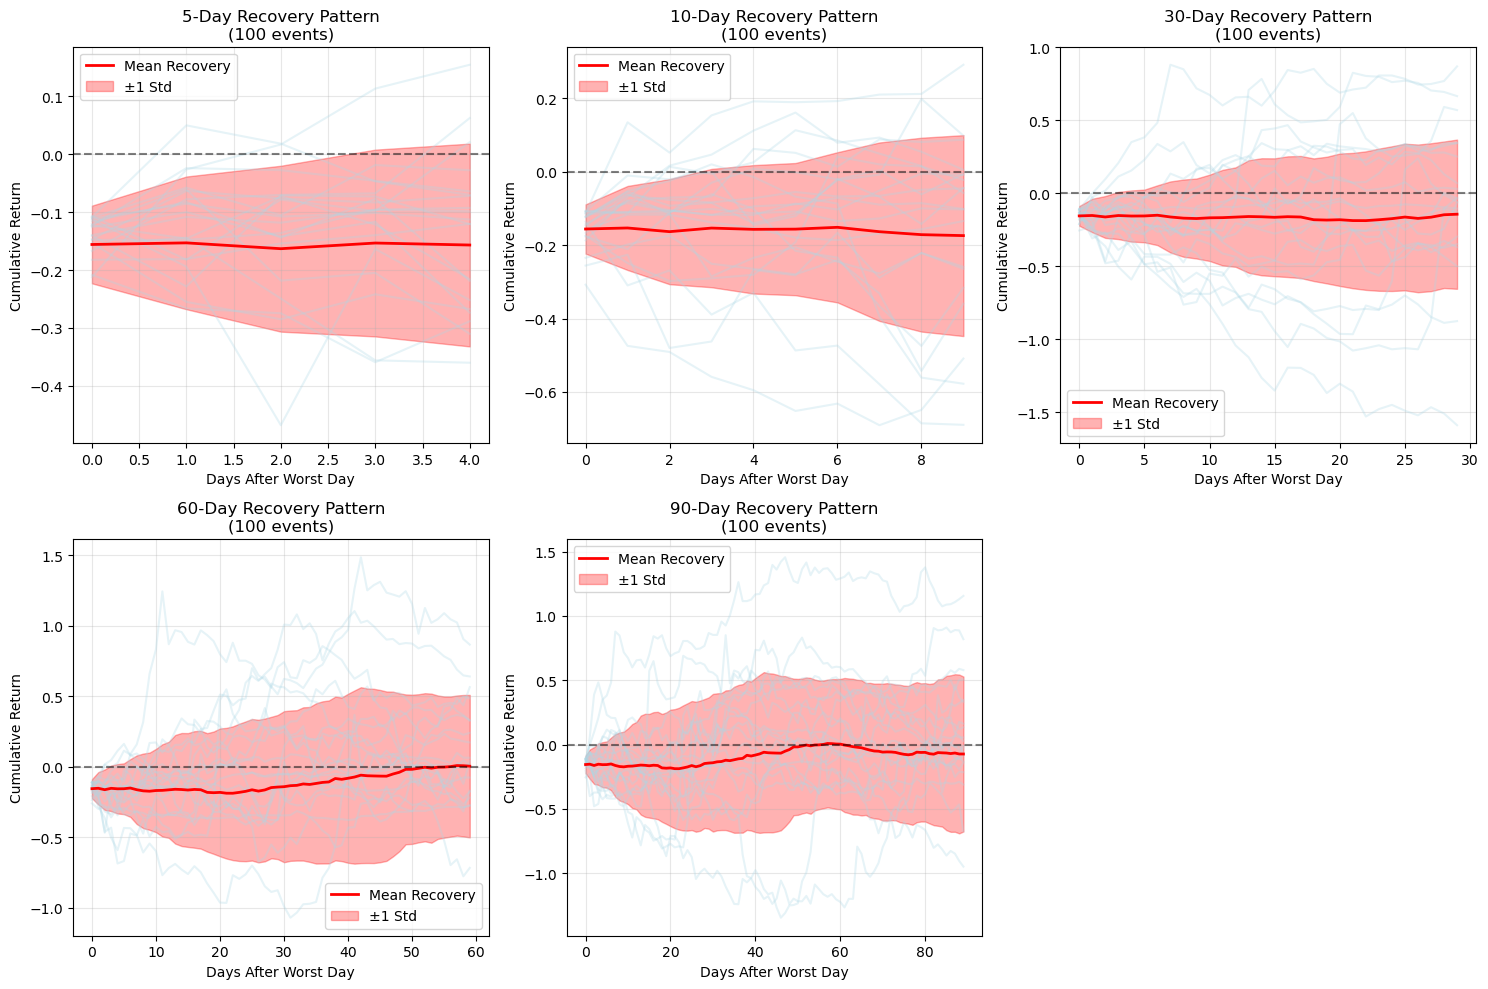


S&P 500 RECOVERY ANALYSIS AFTER WORST DAYS

5-Day Recovery Window:
  • Average return: -15.68%
  • Probability of positive return: 16%
  • Success rate: 16/100 events
  • Median return: -15.08%
  • Best case: +35.91%
  • Worst case: -68.63%

10-Day Recovery Window:
  • Average return: -17.39%
  • Probability of positive return: 21%
  • Success rate: 21/100 events
  • Median return: -13.89%
  • Best case: +71.72%
  • Worst case: -89.33%

30-Day Recovery Window:
  • Average return: -14.43%
  • Probability of positive return: 32%
  • Success rate: 32/100 events
  • Median return: -12.45%
  • Best case: +86.74%
  • Worst case: -158.85%

60-Day Recovery Window:
  • Average return: +0.38%
  • Probability of positive return: 49%
  • Success rate: 49/100 events
  • Median return: -2.51%
  • Best case: +128.73%
  • Worst case: -130.28%

90-Day Recovery Window:
  • Average return: -7.39%
  • Probability of positive return: 45%
  • Success rate: 45/100 events
  • Median return: -8.08%
  • Best c

In [93]:
# CLEAN RECOVERY ANALYSIS - Final Version
def analyze_recovery_patterns_final():
    """Final clean recovery pattern analysis"""
    
    recovery_stats = {}
    
    for window in window_size:
        print(f"Processing {window}-day window...")
        
        all_recovery_paths = []
        valid_dates = []
        
        for day in worst_days.index:
            try:
                # Find the position of this worst day in our returns series
                day_idx = simple_returns.index.get_loc(day)
                
                # Check if we have enough data after this day
                if day_idx + window <= len(simple_returns):
                    # Get the recovery path (including the worst day itself)
                    recovery_path = simple_returns.iloc[day_idx:day_idx + window].cumsum()
                    all_recovery_paths.append(recovery_path.values)
                    valid_dates.append(day)
                    
            except (KeyError, IndexError):
                continue
        
        if all_recovery_paths:
            # Convert to DataFrame: rows = days, columns = recovery events
            recovery_df = pd.DataFrame(all_recovery_paths).T
            recovery_df.index = range(window)  # Days 0, 1, 2, ..., window-1
            
            # Calculate statistics
            mean_recovery = recovery_df.mean(axis=1)
            median_recovery = recovery_df.median(axis=1)
            std_recovery = recovery_df.std(axis=1)
            
            recovery_stats[window] = {
                'data': recovery_df,
                'mean': mean_recovery,
                'median': median_recovery,
                'std': std_recovery,
                'count': len(all_recovery_paths),
                'valid_dates': valid_dates
            }
            
            print(f"  Successfully processed {len(all_recovery_paths)} recovery events")
        else:
            print(f"  No valid recovery events found")
    
    return recovery_stats

# Run the analysis
print("Running final recovery analysis...")
recovery_analysis = analyze_recovery_patterns_final()

# Visualization
plt.figure(figsize=(15, 10))

for i, window in enumerate(window_size):
    if window in recovery_analysis:
        plt.subplot(2, 3, i+1)
        
        # Plot sample recovery paths
        data = recovery_analysis[window]['data']
        sample_data = data.sample(min(20, data.shape[1]), axis=1)
        plt.plot(sample_data, alpha=0.3, color='lightblue')
        
        # Plot mean and confidence bands
        mean_recovery = recovery_analysis[window]['mean']
        std_recovery = recovery_analysis[window]['std']
        
        days = range(len(mean_recovery))
        plt.plot(days, mean_recovery, 'r-', linewidth=2, label='Mean Recovery')
        plt.fill_between(days, 
                        mean_recovery - std_recovery, 
                        mean_recovery + std_recovery, 
                        alpha=0.3, color='red', label='±1 Std')
        
        plt.title(f'{window}-Day Recovery Pattern\n({recovery_analysis[window]["count"]} events)')
        plt.xlabel('Days After Worst Day')
        plt.ylabel('Cumulative Return')
        plt.grid(True, alpha=0.3)
        plt.legend()
        plt.axhline(y=0, color='black', linestyle='--', alpha=0.5)

plt.tight_layout()
plt.show()

# Final Statistics
print("\n" + "="*60)
print("S&P 500 RECOVERY ANALYSIS AFTER WORST DAYS")
print("="*60)

for window in window_size:
    if window in recovery_analysis:
        stats = recovery_analysis[window]
        
        # Get final day returns for all recovery events
        final_day_returns = stats['data'].iloc[-1]
        mean_return = stats['mean'].iloc[-1]
        
        # Calculate probability statistics
        positive_outcomes = (final_day_returns > 0).sum()
        total_outcomes = len(final_day_returns)
        prob_positive = positive_outcomes / total_outcomes
        
        print(f"\n{window}-Day Recovery Window:")
        print(f"  • Average return: {mean_return:+.2%}")
        print(f"  • Probability of positive return: {prob_positive:.0%}")
        print(f"  • Success rate: {positive_outcomes}/{total_outcomes} events")
        print(f"  • Median return: {final_day_returns.median():+.2%}")
        print(f"  • Best case: {final_day_returns.max():+.2%}")
        print(f"  • Worst case: {final_day_returns.min():+.2%}")

print("\n" + "="*60)
print("="*60)

Running analysis for patterns AFTER best days...
Processing 5-day window after best days...
  Successfully processed 100 periods after best days
Processing 10-day window after best days...
  Successfully processed 100 periods after best days
Processing 30-day window after best days...
  Successfully processed 100 periods after best days
Processing 60-day window after best days...
  Successfully processed 100 periods after best days
Processing 90-day window after best days...
  Successfully processed 100 periods after best days


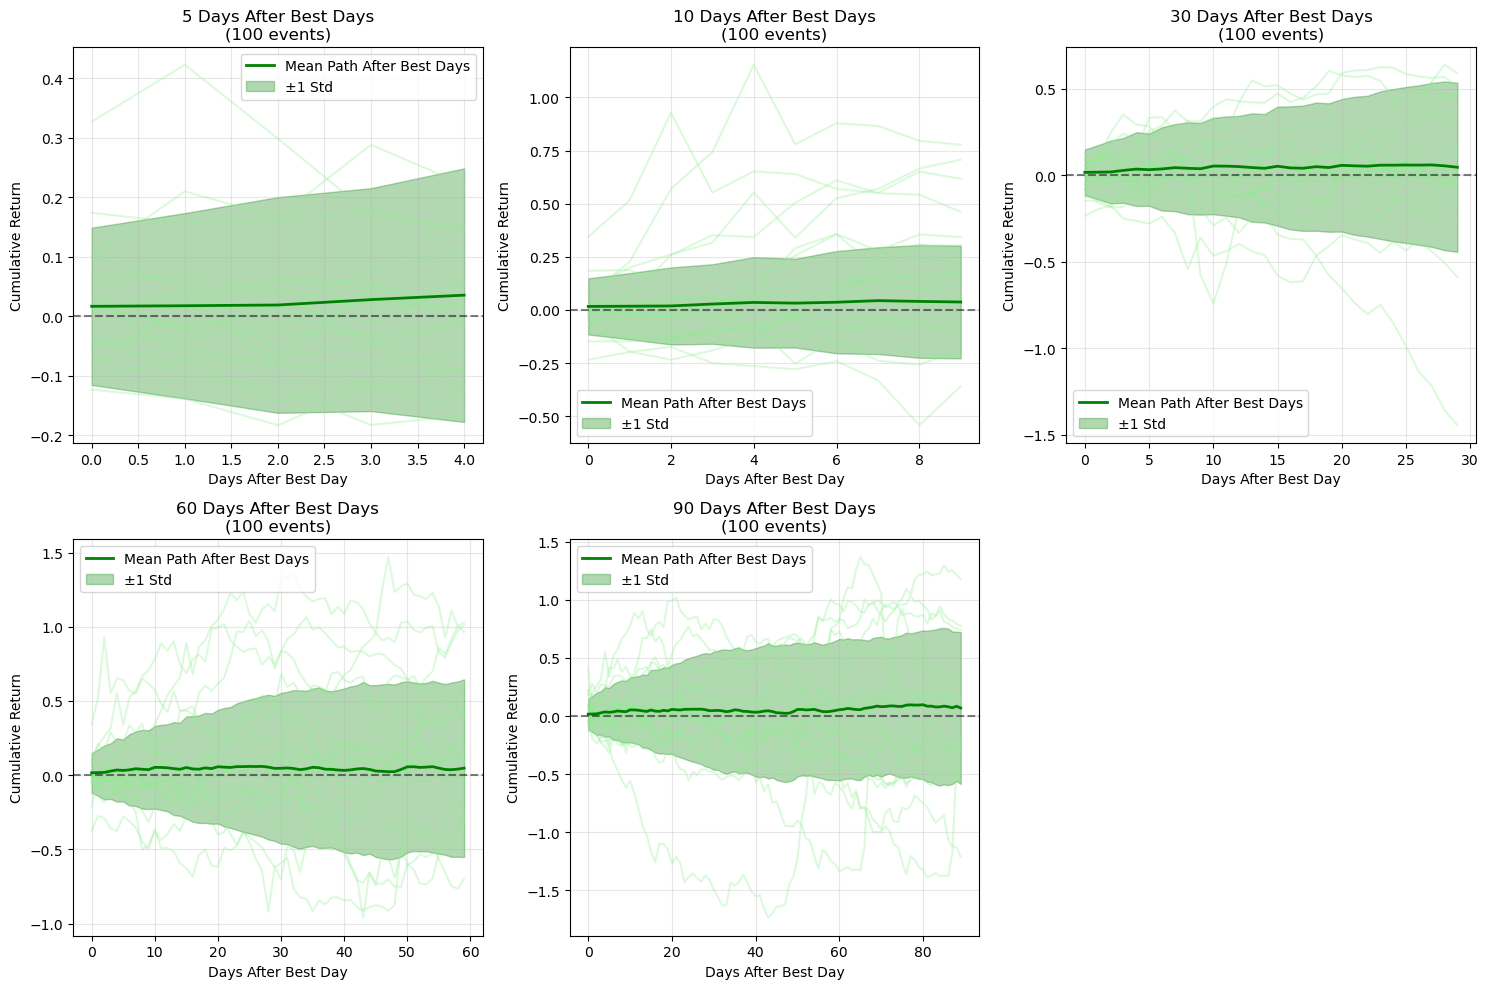


S&P 500 PATTERNS AFTER THE TOP 100 BEST DAYS

5 Days After Big Rally:
  • Average return: +3.53%
  • Probability of continued gains: 49%
  • Probability of pullback: 51%
  • Continued gains: 49/100 events
  • Pullbacks: 51/100 events
  • Median return: -0.22%
  • Best case: +115.40%
  • Worst case: -37.67%

10 Days After Big Rally:
  • Average return: +3.74%
  • Probability of continued gains: 58%
  • Probability of pullback: 42%
  • Continued gains: 58/100 events
  • Pullbacks: 42/100 events
  • Median return: +4.91%
  • Best case: +86.08%
  • Worst case: -61.49%

30 Days After Big Rally:
  • Average return: +4.59%
  • Probability of continued gains: 57%
  • Probability of pullback: 43%
  • Continued gains: 57/100 events
  • Pullbacks: 43/100 events
  • Median return: +4.35%
  • Best case: +112.88%
  • Worst case: -158.30%

60 Days After Big Rally:
  • Average return: +4.74%
  • Probability of continued gains: 56%
  • Probability of pullback: 44%
  • Continued gains: 56/100 events
  

In [94]:
# ================================================================
# ANALYSIS OF PATTERNS AFTER THE TOP 100 BEST DAYS
# ================================================================

# CLEAN ANALYSIS FOR BEST DAYS - What happens after major rallies?
def analyze_patterns_after_best_days():
    """Analyze what happens after the top 100 best market days"""
    
    best_day_stats = {}
    
    for window in window_size:
        print(f"Processing {window}-day window after best days...")
        
        all_paths_after_best = []
        valid_dates = []
        
        for day in best_days.index:
            try:
                # Find the position of this best day in our returns series
                day_idx = simple_returns.index.get_loc(day)
                
                # Check if we have enough data after this day
                if day_idx + window <= len(simple_returns):
                    # Get the path AFTER the best day (starting from day+1, not including the best day itself)
                    path_after = simple_returns.iloc[day_idx + 1:day_idx + 1 + window].cumsum()
                    all_paths_after_best.append(path_after.values)
                    valid_dates.append(day)
                    
            except (KeyError, IndexError):
                continue
        
        if all_paths_after_best:
            # Convert to DataFrame: rows = days, columns = events after best days
            paths_df = pd.DataFrame(all_paths_after_best).T
            paths_df.index = range(window)  # Days 1, 2, 3, ..., window after best day
            
            # Calculate statistics
            mean_path = paths_df.mean(axis=1)
            median_path = paths_df.median(axis=1)
            std_path = paths_df.std(axis=1)
            
            best_day_stats[window] = {
                'data': paths_df,
                'mean': mean_path,
                'median': median_path,
                'std': std_path,
                'count': len(all_paths_after_best),
                'valid_dates': valid_dates
            }
            
            print(f"  Successfully processed {len(all_paths_after_best)} periods after best days")
        else:
            print(f"  No valid periods found")
    
    return best_day_stats

# Run the analysis for best days
print("Running analysis for patterns AFTER best days...")
best_day_analysis = analyze_patterns_after_best_days()

# Visualization - What happens AFTER best days
plt.figure(figsize=(15, 10))

for i, window in enumerate(window_size):
    if window in best_day_analysis:
        plt.subplot(2, 3, i+1)
        
        # Plot sample paths after best days
        data = best_day_analysis[window]['data']
        sample_data = data.sample(min(20, data.shape[1]), axis=1)
        plt.plot(sample_data, alpha=0.3, color='lightgreen')
        
        # Plot mean and confidence bands
        mean_path = best_day_analysis[window]['mean']
        std_path = best_day_analysis[window]['std']
        
        days = range(len(mean_path))
        plt.plot(days, mean_path, 'g-', linewidth=2, label='Mean Path After Best Days')
        plt.fill_between(days, 
                        mean_path - std_path, 
                        mean_path + std_path, 
                        alpha=0.3, color='green', label='±1 Std')
        
        plt.title(f'{window} Days After Best Days\n({best_day_analysis[window]["count"]} events)')
        plt.xlabel('Days After Best Day')
        plt.ylabel('Cumulative Return')
        plt.grid(True, alpha=0.3)
        plt.legend()
        plt.axhline(y=0, color='black', linestyle='--', alpha=0.5)

plt.tight_layout()
plt.show()

# Statistics for what happens AFTER best days
print("\n" + "="*60)
print("S&P 500 PATTERNS AFTER THE TOP 100 BEST DAYS")
print("="*60)

for window in window_size:
    if window in best_day_analysis:
        stats = best_day_analysis[window]
        
        # Get final day returns for all periods after best days
        final_day_returns = stats['data'].iloc[-1]
        mean_return = stats['mean'].iloc[-1]
        
        # Calculate probability statistics
        positive_outcomes = (final_day_returns > 0).sum()
        total_outcomes = len(final_day_returns)
        prob_positive = positive_outcomes / total_outcomes
        
        # Calculate negative outcomes (pullbacks after rallies)
        negative_outcomes = (final_day_returns < 0).sum()
        prob_negative = negative_outcomes / total_outcomes
        
        print(f"\n{window} Days After Big Rally:")
        print(f"  • Average return: {mean_return:+.2%}")
        print(f"  • Probability of continued gains: {prob_positive:.0%}")
        print(f"  • Probability of pullback: {prob_negative:.0%}")
        print(f"  • Continued gains: {positive_outcomes}/{total_outcomes} events")
        print(f"  • Pullbacks: {negative_outcomes}/{total_outcomes} events")
        print(f"  • Median return: {final_day_returns.median():+.2%}")
        print(f"  • Best case: {final_day_returns.max():+.2%}")
        print(f"  • Worst case: {final_day_returns.min():+.2%}")

print("\n" + "="*60)
print("="*60)

# COMPARATIVE ANALYSIS: Best Days vs Worst Days
print("\n" + "="*80)
print("COMPARATIVE ANALYSIS: AFTER BEST DAYS vs AFTER WORST DAYS")
print("="*80)

# Create comparison table
comparison_data = []
for window in window_size:
    if window in recovery_analysis and window in best_day_analysis:
        # After worst days (recovery analysis)
        worst_mean = recovery_analysis[window]['mean'].iloc[-1]
        worst_prob_positive = (recovery_analysis[window]['data'].iloc[-1] > 0).mean()
        
        # After best days
        best_mean = best_day_analysis[window]['mean'].iloc[-1]
        best_prob_positive = (best_day_analysis[window]['data'].iloc[-1] > 0).mean()
        
        comparison_data.append({
            'Window': f'{window} days',
            'After_Worst_Mean': f'{worst_mean:+.2%}',
            'After_Worst_Success': f'{worst_prob_positive:.0%}',
            'After_Best_Mean': f'{best_mean:+.2%}',
            'After_Best_Success': f'{best_prob_positive:.0%}',
            'Difference': f'{best_mean - worst_mean:+.2%}'
        })

comparison_df = pd.DataFrame(comparison_data)
print(comparison_df.to_string(index=False))

print("\n" + "="*80)
print("STRATEGIC IMPLICATIONS:")
print("• Market timing: Compare recovery odds vs post-rally risks")
print("• Contrarian vs momentum: Which approach works better at different horizons?")
print("• Portfolio rebalancing: When to buy dips vs take profits")
print("="*80)

In [95]:
# FIXED VERSION - Create DataFrame with proper structure
# Create DataFrames instead of adding columns to Series
worst_days_df = pd.DataFrame({
    'return': worst_days.values,
    'day_type': 'worst'
}, index=worst_days.index)

best_days_df = pd.DataFrame({
    'return': best_days.values,
    'day_type': 'best'
}, index=best_days.index)

# concatenate the two dataframes
worst_and_best = pd.concat([worst_days_df, best_days_df])

# sort by index (date)
worst_and_best = worst_and_best.sort_index()

# print shape and head
print("Combined DataFrame shape:", worst_and_best.shape)
print("\nFirst few rows:")
print(worst_and_best.head())

print("\nLast few rows:")
print(worst_and_best.tail())

print("\nValue counts by day type:")
print(worst_and_best['day_type'].value_counts())

print("\nSample of worst days:")
print(worst_and_best[worst_and_best['day_type'] == 'worst'].head())

print("\nSample of best days:")
print(worst_and_best[worst_and_best['day_type'] == 'best'].head())

Combined DataFrame shape: (200, 2)

First few rows:
              return day_type
Date                         
1998-06-18  0.136612     best
1998-07-13  0.256000     best
1998-08-31 -0.163082    worst
1998-09-08  0.186528     best
1998-09-14  0.183223     best

Last few rows:
              return day_type
Date                         
2025-02-25 -0.114054    worst
2025-03-10 -0.166829    worst
2025-03-28 -0.108383    worst
2025-04-08 -0.112590    worst
2025-04-09  0.247573     best

Value counts by day type:
day_type
best     100
worst    100
Name: count, dtype: int64

Sample of worst days:
              return day_type
Date                         
1998-08-31 -0.163082    worst
1998-10-06 -0.113248    worst
1998-10-13 -0.122768    worst
1998-10-30 -0.123596    worst
1998-12-30 -0.130682    worst

Sample of best days:
              return day_type
Date                         
1998-06-18  0.136612     best
1998-07-13  0.256000     best
1998-09-08  0.186528     best
1998-09-14  0.18322

In [96]:
# lambda function to calculate the difference in days between two consecutive dates
worst_and_best['days_since_last'] = worst_and_best.index.to_series().diff().dt.days.fillna(0).astype(int)

# print the first few rows to verify
print("\nFirst few rows with days_since_last:")
print(worst_and_best.head())


First few rows with days_since_last:
              return day_type  days_since_last
Date                                          
1998-06-18  0.136612     best                0
1998-07-13  0.256000     best               25
1998-08-31 -0.163082    worst               49
1998-09-08  0.186528     best                8
1998-09-14  0.183223     best                6


In [97]:
worst_and_best.head(10)

,return,day_type,days_since_last
Date,,,
1998-06-18,0.136612,best,0
1998-07-13,0.256000,best,25
1998-08-31,-0.163082,worst,49
1998-09-08,0.186528,best,8
1998-09-14,0.183223,best,6
1998-10-06,-0.113248,worst,22
1998-10-09,0.214286,best,3
1998-10-13,-0.122768,worst,4
1998-10-29,0.164921,best,16


PROBABILITY ANALYSIS: WORST DAYS FOLLOWED BY BEST DAYS

Analyzing 5-day window...
  • Probability: 16.0%
  • Success cases: 16/100
  • Average days to recovery: 2.2

Analyzing 10-day window...
  • Probability: 31.0%
  • Success cases: 31/100
  • Average days to recovery: 4.9

Analyzing 30-day window...
  • Probability: 63.0%
  • Success cases: 63/100
  • Average days to recovery: 11.2

Analyzing 60-day window...
  • Probability: 78.0%
  • Success cases: 78/100
  • Average days to recovery: 18.6

Analyzing 90-day window...
  • Probability: 81.0%
  • Success cases: 81/100
  • Average days to recovery: 20.4

SUMMARY: PROBABILITY OF BEST DAY AFTER WORST DAY
 Window (Days) Probability Success Rate Avg Days to Recovery Median Days Range
             5       16.0%       16/100                  2.2         1.5   1-5
            10       31.0%       31/100                  4.9         5.0  1-10
            30       63.0%       63/100                 11.2        11.0  1-30
            60       7

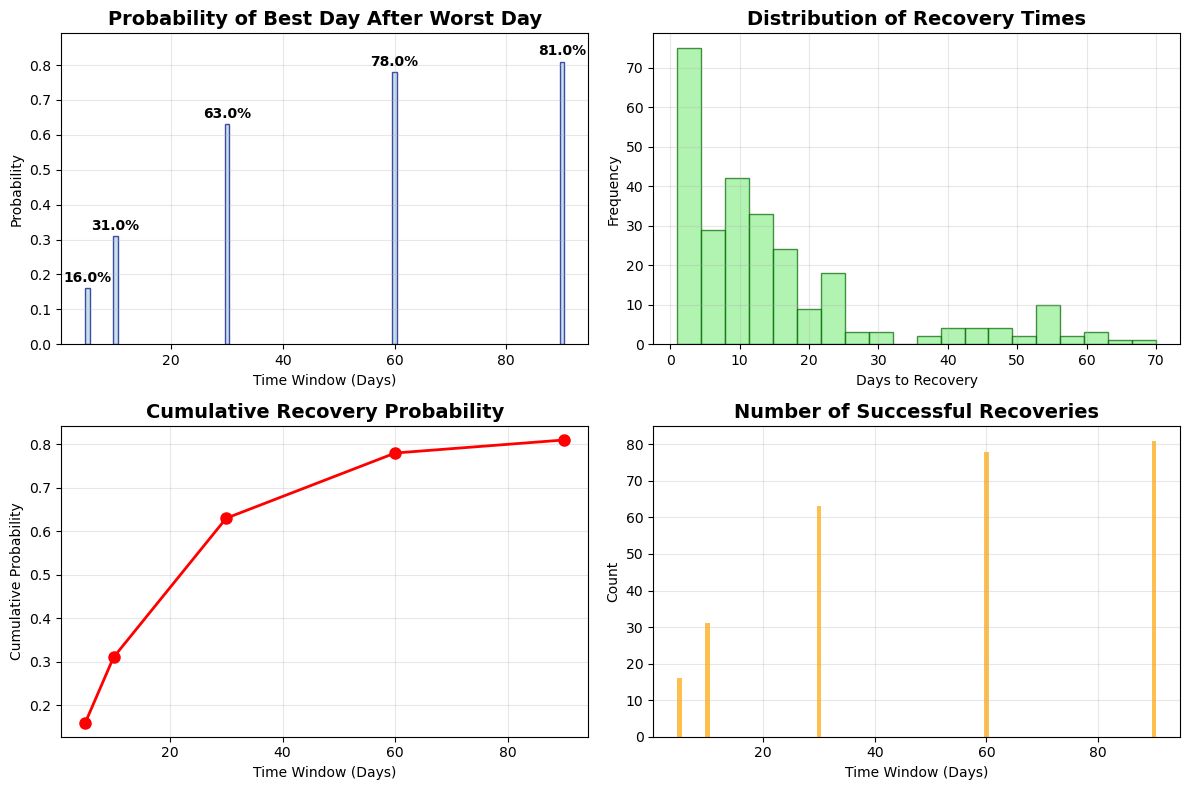


SAMPLE SUCCESSFUL RECOVERY CASES (30-day window)
 1. Worst day: 1998-08-31 (-16.31%)
    Best day:  1998-09-08 (+18.65%)
    Recovery:  8 days

 2. Worst day: 1998-10-06 (-11.32%)
    Best day:  1998-10-09 (+21.43%)
    Recovery:  3 days

 3. Worst day: 1998-10-13 (-12.28%)
    Best day:  1998-10-29 (+16.49%)
    Recovery:  16 days

 4. Worst day: 1999-12-14 (-15.29%)
    Best day:  1999-12-28 (+20.43%)
    Recovery:  14 days

 5. Worst day: 2000-03-20 (-61.74%)
    Best day:  2000-03-22 (+22.71%)
    Recovery:  2 days

 6. Worst day: 2000-03-21 (-16.64%)
    Best day:  2000-03-22 (+22.71%)
    Recovery:  1 days

 7. Worst day: 2000-03-27 (-12.40%)
    Best day:  2000-04-18 (+15.71%)
    Recovery:  22 days

 8. Worst day: 2000-03-28 (-12.83%)
    Best day:  2000-04-18 (+15.71%)
    Recovery:  21 days

 9. Worst day: 2000-04-03 (-11.41%)
    Best day:  2000-04-18 (+15.71%)
    Recovery:  15 days

10. Worst day: 2000-04-11 (-13.45%)
    Best day:  2000-04-18 (+15.71%)
    Recovery:  7 d

In [98]:
# ================================================================
# PROBABILITY ANALYSIS: WORST DAYS FOLLOWED BY BEST DAYS
# ================================================================

def analyze_worst_to_best_probability(worst_and_best_df, window_sizes):
    """
    Calculate the probability that after a worst day, we get a best day within different time windows
    """
    
    results = {}
    
    # Get only worst days
    worst_days_only = worst_and_best_df[worst_and_best_df['day_type'] == 'worst'].copy()
    
    print("="*70)
    print("PROBABILITY ANALYSIS: WORST DAYS FOLLOWED BY BEST DAYS")
    print("="*70)
    
    for window in window_sizes:
        print(f"\nAnalyzing {window}-day window...")
        
        success_count = 0
        total_worst_days = 0
        successful_dates = []
        
        for worst_date in worst_days_only.index:
            total_worst_days += 1
            
            # Define the window after this worst day
            window_start = worst_date + pd.Timedelta(days=1)  # Start from next day
            window_end = worst_date + pd.Timedelta(days=window)
            
            # Check if there's a best day within this window
            best_days_in_window = worst_and_best_df[
                (worst_and_best_df.index > worst_date) & 
                (worst_and_best_df.index <= window_end) & 
                (worst_and_best_df['day_type'] == 'best')
            ]
            
            if len(best_days_in_window) > 0:
                success_count += 1
                # Get the first best day in the window
                first_best_day = best_days_in_window.index[0]
                days_to_recovery = (first_best_day - worst_date).days
                successful_dates.append({
                    'worst_date': worst_date,
                    'best_date': first_best_day,
                    'days_to_recovery': days_to_recovery,
                    'worst_return': worst_and_best_df.loc[worst_date, 'return'],
                    'best_return': worst_and_best_df.loc[first_best_day, 'return']
                })
        
        # Calculate probability
        probability = success_count / total_worst_days if total_worst_days > 0 else 0
        
        results[window] = {
            'probability': probability,
            'success_count': success_count,
            'total_worst_days': total_worst_days,
            'successful_cases': successful_dates
        }
        
        print(f"  • Probability: {probability:.1%}")
        print(f"  • Success cases: {success_count}/{total_worst_days}")
        
        # Show average days to recovery
        if successful_dates:
            avg_days = np.mean([case['days_to_recovery'] for case in successful_dates])
            print(f"  • Average days to recovery: {avg_days:.1f}")
    
    return results

# Run the analysis
window_sizes = [5, 10, 30, 60, 90]
recovery_probabilities = analyze_worst_to_best_probability(worst_and_best, window_sizes)

# ================================================================
# DETAILED RESULTS AND VISUALIZATION
# ================================================================

# Create summary table
summary_data = []
for window in window_sizes:
    stats = recovery_probabilities[window]
    
    # Calculate additional statistics
    if stats['successful_cases']:
        avg_days = np.mean([case['days_to_recovery'] for case in stats['successful_cases']])
        median_days = np.median([case['days_to_recovery'] for case in stats['successful_cases']])
        min_days = min([case['days_to_recovery'] for case in stats['successful_cases']])
        max_days = max([case['days_to_recovery'] for case in stats['successful_cases']])
    else:
        avg_days = median_days = min_days = max_days = np.nan
    
    summary_data.append({
        'Window (Days)': window,
        'Probability': f"{stats['probability']:.1%}",
        'Success Rate': f"{stats['success_count']}/{stats['total_worst_days']}",
        'Avg Days to Recovery': f"{avg_days:.1f}" if not np.isnan(avg_days) else "N/A",
        'Median Days': f"{median_days:.1f}" if not np.isnan(median_days) else "N/A",
        'Range': f"{min_days}-{max_days}" if not np.isnan(min_days) else "N/A"
    })

summary_df = pd.DataFrame(summary_data)
print("\n" + "="*80)
print("SUMMARY: PROBABILITY OF BEST DAY AFTER WORST DAY")
print("="*80)
print(summary_df.to_string(index=False))

# ================================================================
# VISUALIZATION: PROBABILITY BY WINDOW SIZE
# ================================================================

plt.figure(figsize=(12, 8))

# Extract probabilities for plotting
windows = list(recovery_probabilities.keys())
probabilities = [recovery_probabilities[w]['probability'] for w in windows]

# Create bar plot
plt.subplot(2, 2, 1)
bars = plt.bar(windows, probabilities, color='lightblue', edgecolor='navy', alpha=0.7)
plt.title('Probability of Best Day After Worst Day', fontsize=14, fontweight='bold')
plt.xlabel('Time Window (Days)')
plt.ylabel('Probability')
plt.ylim(0, max(probabilities) * 1.1)

# Add percentage labels on bars
for bar, prob in zip(bars, probabilities):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01, 
             f'{prob:.1%}', ha='center', va='bottom', fontweight='bold')

plt.grid(True, alpha=0.3)

# Recovery time distribution
plt.subplot(2, 2, 2)
all_recovery_times = []
for window in windows:
    if recovery_probabilities[window]['successful_cases']:
        recovery_times = [case['days_to_recovery'] for case in recovery_probabilities[window]['successful_cases']]
        all_recovery_times.extend(recovery_times)

if all_recovery_times:
    plt.hist(all_recovery_times, bins=20, color='lightgreen', alpha=0.7, edgecolor='darkgreen')
    plt.title('Distribution of Recovery Times', fontsize=14, fontweight='bold')
    plt.xlabel('Days to Recovery')
    plt.ylabel('Frequency')
    plt.grid(True, alpha=0.3)

# Cumulative probability
plt.subplot(2, 2, 3)
plt.plot(windows, probabilities, marker='o', linewidth=2, markersize=8, color='red')
plt.title('Cumulative Recovery Probability', fontsize=14, fontweight='bold')
plt.xlabel('Time Window (Days)')
plt.ylabel('Cumulative Probability')
plt.grid(True, alpha=0.3)

# Success count comparison
plt.subplot(2, 2, 4)
success_counts = [recovery_probabilities[w]['success_count'] for w in windows]
plt.bar(windows, success_counts, color='orange', alpha=0.7)
plt.title('Number of Successful Recoveries', fontsize=14, fontweight='bold')
plt.xlabel('Time Window (Days)')
plt.ylabel('Count')
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# ================================================================
# SAMPLE SUCCESSFUL CASES
# ================================================================

print("\n" + "="*80)
print("SAMPLE SUCCESSFUL RECOVERY CASES (30-day window)")
print("="*80)

if recovery_probabilities[30]['successful_cases']:
    sample_cases = recovery_probabilities[30]['successful_cases'][:10]  # First 10 cases
    
    for i, case in enumerate(sample_cases, 1):
        print(f"{i:2d}. Worst day: {case['worst_date'].strftime('%Y-%m-%d')} ({case['worst_return']:+.2%})")
        print(f"    Best day:  {case['best_date'].strftime('%Y-%m-%d')} ({case['best_return']:+.2%})")
        print(f"    Recovery:  {case['days_to_recovery']} days")
        print()

print("="*80)
print("="*80)